In [19]:
!pip install requests
    


In [ ]:
import os
import requests
import csv
from datetime import datetime, timezone
import time

def fetch_data_from_api(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Failed to fetch data")
        return None

def add_timestamp_to_data(data, timestamp):
    if data:
        for subarray_index, subarray in enumerate(data):
            for entry in subarray:
                entry['timestamp'] = timestamp
                entry['subarray'] = subarray_index
        return data
    else:
        return None

def save_to_csv(data, file_path):
    if data:
        with open(file_path, 'w', newline='') as csvfile:
            fieldnames = ['x', 'y', 'timestamp', 'subarray']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for subarray in data:
                writer.writerows(subarray)

def check_integrity(data, file_path):
    with open(file_path, 'r') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        csv_data = list(csv_reader)
        original_row_count = sum(len(subarray) for subarray in data)
        csv_row_count = len(csv_data)
        if original_row_count == csv_row_count:
            print(f"CSV file '{file_path}' integrity check passed.")
        else:
            print(f"CSV file '{file_path}' integrity check failed.")

api_url = 'https://energie.theoxygent.nl/api/prices_v2.php'

# Create subfolder if it doesn't exist
subfolder = 'oxygent_data'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

while True:
    current_time_gmt = datetime.now(timezone.utc).isoformat()
    file_timestamp = datetime.now(timezone.utc).strftime("%Y%m%d %H:%M")
    time_series_data = fetch_data_from_api(api_url) 
    time_series_data_with_timestamp = add_timestamp_to_data(time_series_data, current_time_gmt)
    csv_file_path = os.path.join(subfolder, f'time_series_data_{file_timestamp}.csv')
    save_to_csv(time_series_data_with_timestamp, csv_file_path)
    check_integrity(time_series_data_with_timestamp, csv_file_path)
    # Fetch data every hour
    time.sleep(3600)


CSV file 'oxygent_data/time_series_data_20250228 08:15.csv' integrity check passed.


stop above code, then proceed with the below codes, can be run all at once 

In [30]:
import os
import pandas as pd
import glob

# Define the folder containing the CSV files
folder_path = "oxygent_data"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv")) + glob.glob(os.path.join(folder_path, "*.CSV"))

# Sort files based on timestamp in filename
csv_files.sort(key=lambda x: x.split("_")[-1].replace(":", "").replace(".csv", "").replace(".CSV", ""))

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
merged_df = pd.concat(df_list, ignore_index=True)

# Save the merged data
merged_df.to_csv("merged_data.csv", index=False)

print(f"Merged {len(csv_files)} files into 'merged_data.csv'")

Merged 100 files into 'merged_data.csv'


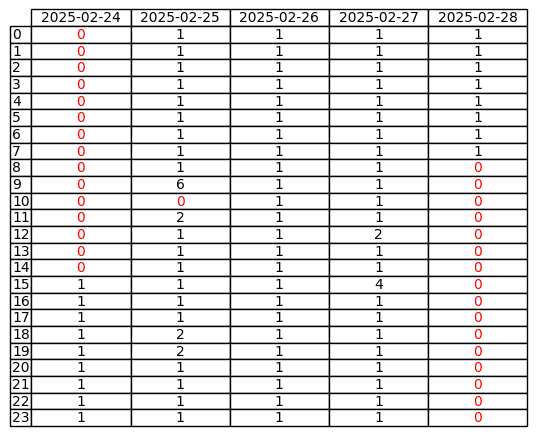

In [31]:
# Convert the 'timestamp' column to datetime in ISO 8601 format
merged_df['timestamp_iso'] = pd.to_datetime(merged_df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S.%f%z')

# Extract dates from the 'timestamp_iso' column
merged_df['date_timestamp'] = pd.to_datetime(merged_df['timestamp_iso']).dt.date
# Extract hour from the 'timestamp_iso' column
merged_df['hour_timestamp'] = pd.to_datetime(merged_df['timestamp_iso']).dt.hour


# Create a pivot table to show unique combinations of hour_timestamp and date_timestamp
pivot_table = merged_df.pivot_table(index='hour_timestamp', columns='date_timestamp', values='timestamp', aggfunc='nunique', fill_value=0)

# Print the pivot table with grids and highlight count values of '0' in red font
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pivot_table.values, colLabels=pivot_table.columns, rowLabels=pivot_table.index, cellLoc='center', loc='center')

# Apply styles to the table
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if i > 0 and j > -1 and pivot_table.iat[i-1, j] == 0:
        cell.set_text_props(color='red')

plt.show()

In [26]:
#creating a leaner dataframe, excluding non-relevant columns
lean_df = merged_df.drop(columns=['timestamp', 'timestamp_iso'])
print(lean_df.columns)

Index(['x', 'y', 'subarray', 'date_timestamp', 'hour_timestamp'], dtype='object')


In [34]:
from datetime import datetime

#conversion of x to datetime
def add_datetime_column(df):
    # Convert x values to milliseconds and then to datetime
    lean_df['date_time'] = lean_df['x'].apply(lambda x: datetime.fromtimestamp(x * 100000 / 1000))
    return df

# Assuming df is already defined in the previous cell
lean_df['Price'] = lean_df['y'].apply(lambda y: (y * 1.21) + 0.1228)  # Calculate price values

# Add the date_time column
lean_df = add_datetime_column(lean_df)

print(lean_df.columns)
print(lean_df.head(2))
print(lean_df.tail(2))

Index(['x', 'y', 'subarray', 'date_timestamp', 'hour_timestamp', 'Price',
       'date_time'],
      dtype='object')
            x        y  subarray date_timestamp  hour_timestamp     Price  \
0  17403516.0  0.01000         0     2025-02-25               0  0.134900   
1  17403552.0  0.01189         0     2025-02-25               0  0.137187   

            date_time  
0 2025-02-24 00:00:00  
1 2025-02-24 01:00:00  
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
101618  17410392.0  0.112         5     2025-02-24              23  0.25832   
101619  17410428.0  0.116         5     2025-02-24              23  0.26316   

                 date_time  
101618 2025-03-03 23:00:00  
101619 2025-03-04 00:00:00  


In [41]:
# Reorder rows based on date_timestamp and hour_timestamp in ascending order
lean_df = lean_df.sort_values(by=['date_timestamp', 'hour_timestamp'], ascending=[True, True])

print("head values")
print(lean_df.head(2))
print()
print("tail values ")
print(lean_df.tail(2))

head values
                x        y  subarray date_timestamp  hour_timestamp     Price  \
10415  17403516.0  0.01000         0     2025-02-24              15  0.134900   
10416  17403552.0  0.01189         0     2025-02-24              15  0.137187   

                date_time  
10415 2025-02-24 00:00:00  
10416 2025-02-24 01:00:00  

tail values 
                x      y  subarray date_timestamp  hour_timestamp    Price  \
99595  17413272.0  0.146         5     2025-02-28               7  0.29946   
99596  17413308.0  0.152         5     2025-02-28               7  0.30672   

                date_time  
99595 2025-03-07 07:00:00  
99596 2025-03-07 08:00:00  


In [44]:
# Filter lean_df to create point_est_price_df, only showing subarray 1
point_est_price_df = lean_df[lean_df['subarray'] == 1]

# Print the head and tail rows of point_est_price_df
print("head values")
print(point_est_price_df.head(2))
print()
print("tail values")
print(point_est_price_df.tail(2))

head values
                x      y  subarray date_timestamp  hour_timestamp    Price  \
10464  17403516.0  0.152         1     2025-02-24              15  0.30672   
10465  17403552.0  0.145         1     2025-02-24              15  0.29825   

                date_time  
10464 2025-02-24 00:00:00  
10465 2025-02-24 01:00:00  

tail values
                x      y  subarray date_timestamp  hour_timestamp    Price  \
98791  17413272.0  0.157         1     2025-02-28               7  0.31277   
98792  17413308.0  0.162         1     2025-02-28               7  0.31882   

                date_time  
98791 2025-03-07 07:00:00  
98792 2025-03-07 08:00:00  


// Price values match price shown on energie.theoxigent.nl, confirmed by checking 5 price values most into the future. Based on CSV file 'oxygent_data/time_series_data_20250227 15:16.csv' //


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_63835/318856810.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('coolwarm', len(unique_combinations))


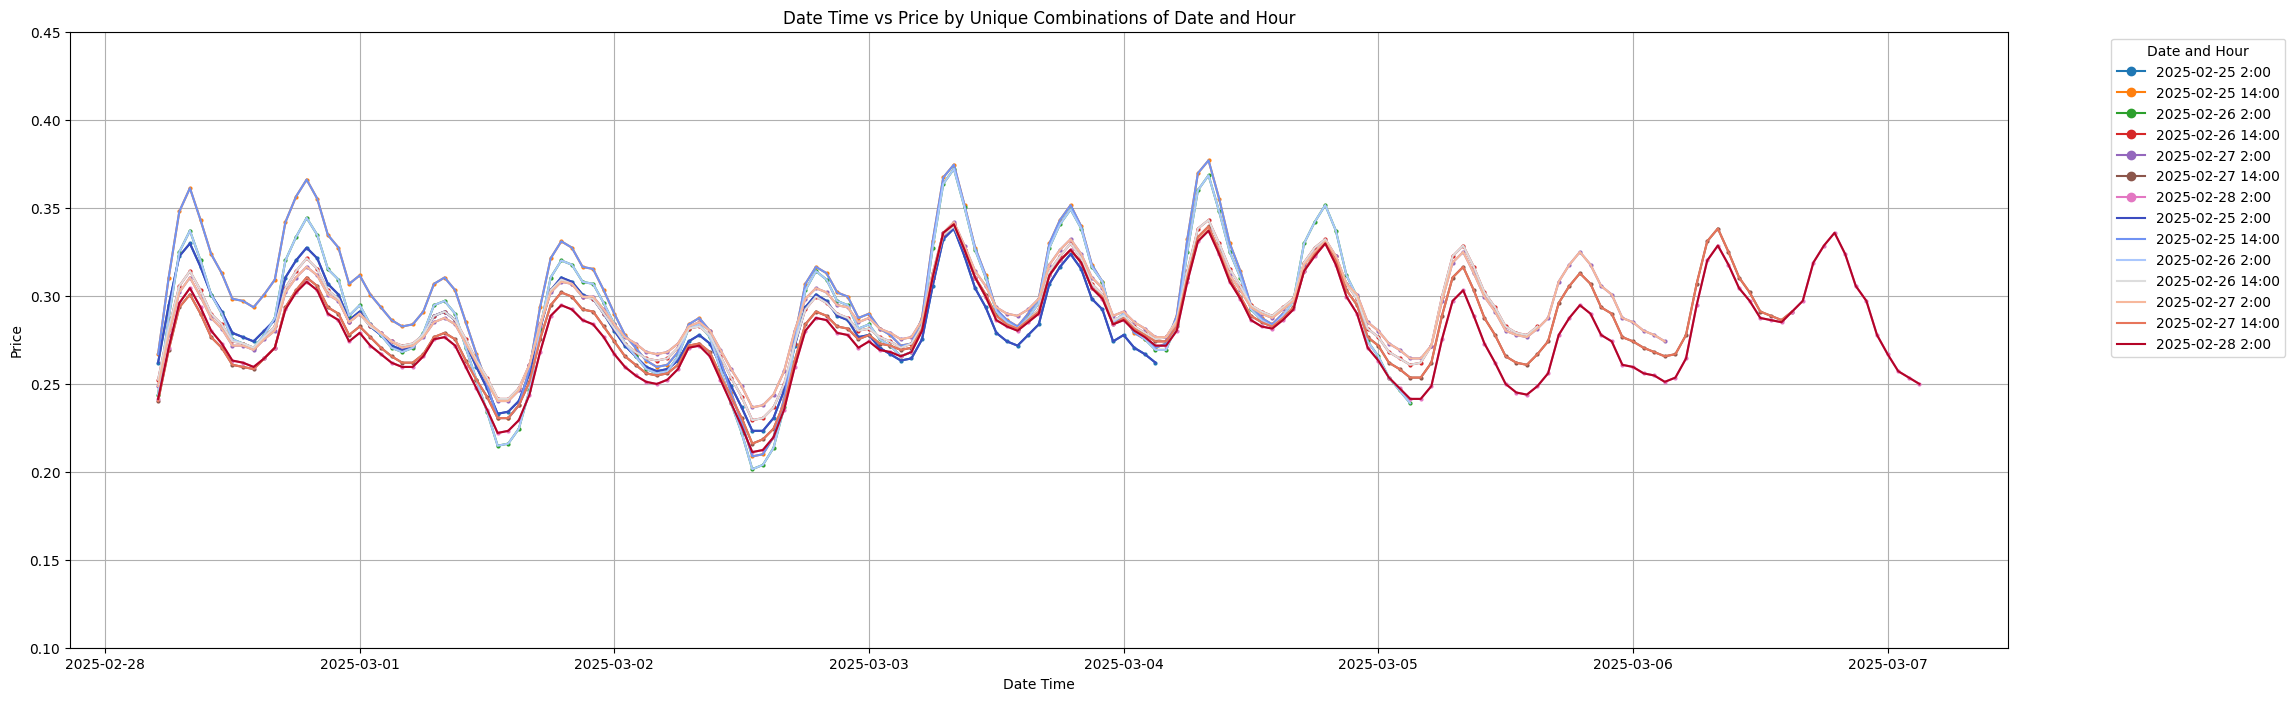

In [46]:
# needs refiment, but potentially can show how estimate evolved for a particular time period
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 14 or 2
filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 14) | (filtered_df['hour_timestamp'] == 2)]

# Plot the filtered data by each unique combination of date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])

plt.figure(figsize=(25, 8))  # Adjust the width to be 5 times wider

for (date_timestamp, hour_timestamp), group in unique_combinations:
    plt.plot(group['date_time'], group['Price'], marker='o', label=f'{date_timestamp} {hour_timestamp}:00')

import matplotlib.cm as cm
# Generate a color map from red to blue
colors = cm.get_cmap('coolwarm', len(unique_combinations))

for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    plt.plot(group['date_time'], group['Price'], color=colors(i), label=f'{date_timestamp} {hour_timestamp}:00')

plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by Unique Combinations of Date and Hour')
plt.ylim(0.10, 0.45)  # Set y-axis limits
plt.legend(title='Date and Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Change the format to dots being 3x smaller
for line in plt.gca().get_lines():
    line.set_markersize(line.get_markersize() / 3)

plt.show()
